In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import calendar
import datetime as dt
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error
import seaborn as sns
plt.style.use('seaborn-whitegrid')

In [2]:
pd.options.display.float_format = "{:.3f}".format

In [3]:
n_rows = 5000000
data = pd.read_csv("data.csv", nrows = n_rows)
test = pd.read_csv("test.csv")

In [4]:
print(data.shape)
print(test.shape)

(5000000, 8)
(9914, 7)


Tabs will be objects that I had screenshots of in my thesis

In [5]:
tab1 = pd.DataFrame(data.dtypes, columns = ['column type'])
tab1['number'] = data.count()
tab1

,column type,number
key,object,5000000
fare_amount,float64,5000000
pickup_datetime,object,5000000
pickup_longitude,float64,5000000
pickup_latitude,float64,5000000
dropoff_longitude,float64,4999964
dropoff_latitude,float64,4999964
passenger_count,int64,5000000


In [6]:
tab2 = pd.DataFrame(test.dtypes, columns = ['column type'])
tab2['number'] = test.count()
tab2

,column type,number
key,object,9914
pickup_datetime,object,9914
pickup_longitude,float64,9914
pickup_latitude,float64,9914
dropoff_longitude,float64,9914
dropoff_latitude,float64,9914
passenger_count,int64,9914


Doing just kind of "blind guessing"

In [7]:
mean = round(data['fare_amount'].mean(),2)
print(mean)

y_pred = pd.Series([mean]*int(test.shape[0]))

11.34


In [8]:
### submission
submission = pd.DataFrame({'key':test.key, 'fare_amount':y_pred}, columns=['key','fare_amount'])
submission.to_csv('submission.csv',index=False)

In [9]:
tab3 = pd.DataFrame(data.isna().sum(), columns=['number on NaN cells'])
tab3

,number on NaN cells
key,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,36
dropoff_latitude,36
passenger_count,0


In [10]:
#deleting rows with empty cells
def delete_empty(data):
    data = data.loc[:].dropna(how='any', axis='rows')
    return data

In [11]:
data = delete_empty(data)

In [12]:
print(data.shape)

(4999964, 8)


Prepare data for training data will separate X variables and Y, it also drops columns that are given in 'drop_cols' list 

In [13]:
def prepare_data(data, target, drop_cols, if_training_data):
    data = data.drop(drop_cols,axis=1)
    
    if if_training_data==True:
        y = data[target]
        data = data.drop(target,axis=1)
        X = data
        return X, y
    else:
        return data

In [14]:
X_train, y_train = prepare_data(data, 'fare_amount',['key','pickup_datetime'],True)
test_data = prepare_data(test ,'',['key','pickup_datetime'],False)

#### Trying Linear Regression with raw data (all numerical columns)

In [15]:
lm = LinearRegression()
lm.fit(X_train, y_train)

y_pred = np.round(lm.predict(test_data),2)

submission = pd.DataFrame({'key':test.key, 'fare_amount':y_pred}, columns=['key','fare_amount'])
submission.to_csv('submission.csv',index=False)

In [16]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,4999964.000,4999964.000,4999964.000,4999964.000,4999964.000,4999964.000
mean,11.341,-72.507,39.920,-72.507,39.917,1.685
std,9.820,12.810,8.963,12.848,9.487,1.332
min,-100.000,-3426.609,-3488.080,-3412.653,-3488.080,0.000
25%,6.000,-73.992,40.735,-73.991,40.734,1.000
50%,8.500,-73.982,40.753,-73.980,40.753,1.000
75%,12.500,-73.967,40.767,-73.964,40.768,2.000
max,1273.310,3439.426,3310.364,3457.622,3345.917,208.000


In [17]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000,9914.000,9914.000,9914.000,9914.000
mean,-73.975,40.751,-73.974,40.752,1.671
std,0.043,0.034,0.039,0.035,1.279
min,-74.252,40.573,-74.263,40.569,1.000
25%,-73.993,40.736,-73.991,40.735,1.000
50%,-73.982,40.753,-73.980,40.754,1.000
75%,-73.968,40.767,-73.964,40.769,2.000
max,-72.987,41.710,-72.991,41.697,6.000


In [18]:
def del_impossible_coordinates(data):
    
    granice = {
        'min_lng': -180, 
        'min_lat': -90, 
        'max_lng': 180, 
        'max_lat': 90}
    
    data=data[((data.pickup_longitude >= granice['min_lng']) & 
               (data.pickup_longitude <= granice['max_lng']) & 
               (data.dropoff_longitude >= granice['min_lng']) &
               (data.dropoff_longitude <= granice['max_lng']) &
               (data.pickup_latitude >= granice['min_lat']) &
               (data.pickup_latitude <= granice['max_lat']) &
               (data.dropoff_latitude >= granice['min_lat']) &
               (data.dropoff_latitude <= granice['max_lat']) )]
    return data

In [19]:
# boundires based on test data
def del_outside_boundries_NYC(data):
    
    granice = {
        'min_lng': -74.3, 
        'min_lat': 40.5, 
        'max_lng': -73, 
        'max_lat': 41.75}
    
    data=data[((data.pickup_longitude >= granice['min_lng']) & 
               (data.pickup_longitude <= granice['max_lng']) & 
               (data.dropoff_longitude >= granice['min_lng']) &
               (data.dropoff_longitude <= granice['max_lng']) &
               (data.pickup_latitude >= granice['min_lat']) &
               (data.pickup_latitude <= granice['max_lat']) &
               (data.dropoff_latitude >= granice['min_lat']) &
               (data.dropoff_latitude <= granice['max_lat']) )]
    return data

In [20]:
data = del_impossible_coordinates(data)
data = del_outside_boundries_NYC(data)

In [21]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,4893511.000,4893511.000,4893511.000,4893511.000,4893511.000,4893511.000
mean,11.316,-73.975,40.751,-73.974,40.751,1.685
std,9.662,0.038,0.030,0.037,0.033,1.316
min,-62.000,-74.299,40.500,-74.300,40.500,0.000
25%,6.000,-73.992,40.737,-73.992,40.736,1.000
50%,8.500,-73.982,40.753,-73.981,40.754,1.000
75%,12.500,-73.968,40.768,-73.965,40.768,2.000
max,952.000,-73.012,41.697,-73.012,41.691,208.000


In [22]:
tab4 = pd.DataFrame(data.groupby('passenger_count').size(), columns = ['num of observations'])
tab4

,num of observations
passenger_count,
0,17218
1,3384497
2,723531
3,214794
4,103894
5,346038
6,103533
7,1
9,2


### There are many observations with 0 passengers in ride but it is not siginificant

In [23]:
#deleting rows where passenger count <1 and >6
def del_passengers(data):
    data=data[data['passenger_count']<=6]
    data=data[data['passenger_count']>=1]
    return data

In [24]:
data = del_passengers(data)

In [25]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,4876287.000,4876287.000,4876287.000,4876287.000,4876287.000,4876287.000
mean,11.324,-73.975,40.751,-73.974,40.751,1.690
std,9.671,0.038,0.030,0.037,0.033,1.306
min,-62.000,-74.299,40.500,-74.300,40.500,1.000
25%,6.000,-73.992,40.737,-73.992,40.736,1.000
50%,8.500,-73.982,40.753,-73.981,40.754,1.000
75%,12.500,-73.968,40.768,-73.965,40.768,2.000
max,952.000,-73.012,41.697,-73.012,41.691,6.000


In [26]:
#setting minimal taxi fare to be 2.5$ and maximum 140$
def del_fare(data):
    data = data[(data['fare_amount']>=2.5) & (data['fare_amount']<=140)]
    return data

In [27]:
data = del_fare(data)

In [28]:
X_train, y_train = prepare_data(data, 'fare_amount',['key','pickup_datetime'],True)
test_data = prepare_data(test ,'',['key','pickup_datetime'],False)

In [29]:
lm = LinearRegression()
lm.fit(X_train, y_train)

y_pred = np.round(lm.predict(test_data),2)

submission = pd.DataFrame({'key':test.key, 'fare_amount':y_pred}, columns=['key','fare_amount'])
submission.to_csv('submission.csv',index=False)

In [30]:
#using haversine formula to calculate distance between places using coordinates
#https://en.wikipedia.org/wiki/Haversine_formula
def add_vars_distance(data):
    #radius of earth in km
    R = 6371    
    #degrees to radians
    lon1 = np.deg2rad(data['pickup_longitude'])
    lon2 = np.deg2rad(data['dropoff_longitude'])
    lat1 = np.deg2rad(data['pickup_latitude'])
    lat2 = np.deg2rad(data['dropoff_latitude'])
    
    a = np.sin((lat2-lat1)/2)**2 + ( np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2)**2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    data['euclidean'] = R*c
        
    a1 = np.sin((lat2-lat1)/2)**2 + ( np.cos(lat1) * np.cos(lat2) * np.sin((0)/2)**2)
    a2 = np.sin(0)**2 + ( np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2)**2)
    
    c1 = 2 * np.arctan2(np.sqrt(a1), np.sqrt(1-a1))
    c2 = 2 * np.arctan2(np.sqrt(a2), np.sqrt(1-a2))
    
    data['manhattan'] = R * np.add(c1, c2)
        
    return data

In [31]:
data = add_vars_distance(data)
test = add_vars_distance(test)

In [32]:
data[['euclidean','manhattan']].describe()

,euclidean,manhattan
count,4875503.000,4875503.000
mean,3.326,4.288
std,3.758,5.001
min,0.000,0.000
25%,1.253,1.597
50%,2.153,2.763
75%,3.910,5.038
max,115.596,163.118


In [33]:
test[['euclidean','manhattan']].describe()

,euclidean,manhattan
count,9914.000,9914.000
mean,3.435,4.428
std,3.972,5.313
min,0.000,0.000
25%,1.298,1.654
50%,2.217,2.850
75%,4.045,5.243
max,99.996,141.414


#### Delete rows where distance is too big to be real (over 120km euclidean distance)

In [34]:
def del_distance(data):
    data = data[data['euclidean']<=120]
    return data

In [35]:
data = del_distance(data)

In [36]:
X_train, y_train = prepare_data(data, 'fare_amount',['key','pickup_datetime'],True)
test_data = prepare_data(test ,'',['key','pickup_datetime'],False)

In [37]:
lm = LinearRegression()
lm.fit(X_train, y_train)

y_pred = np.round(lm.predict(test_data),2)

submission = pd.DataFrame({'key':test.key, 'fare_amount':y_pred}, columns=['key','fare_amount'])
submission.to_csv('submission.csv',index=False)

In [38]:
X_train, y_train = prepare_data(data, 'fare_amount',['key','pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],True)
test_data = prepare_data(test ,'',['key','pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],False)

In [39]:
lm = LinearRegression()
lm.fit(X_train, y_train)

y_pred = np.round(lm.predict(test_data),2)

submission = pd.DataFrame({'key':test.key, 'fare_amount':y_pred}, columns=['key','fare_amount'])
submission.to_csv('submission.csv',index=False)

In [40]:
#mappig days of week
def encodeDays(day_of_week):
    day_dict = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
    return day_dict[day_of_week]

In [41]:
def add_vars_date(data):
    data['pickup_datetime']=pd.to_datetime(data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')
    data['pickup_day'] = data['pickup_datetime'].apply(lambda x:x.day)
    data['pickup_hour'] = data['pickup_datetime'].apply(lambda x:x.hour)
    data['pickup_day_of_week'] = data['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
    data['pickup_month'] = data['pickup_datetime'].apply(lambda x:x.month)
    data['pickup_year'] = data['pickup_datetime'].apply(lambda x:x.year)
    data['pickup_day_of_week']=data['pickup_day_of_week'].apply(lambda x:encodeDays(x))
    data['elapsed'] = (data['pickup_datetime']-data['pickup_datetime'].min()).dt.total_seconds()
    return data

In [42]:
data = add_vars_date(data)
test = add_vars_date(test)

In [43]:
palette = sns.color_palette('Paired', 10)
delta = data.sample(30000)

Text(0, 0.5, 'Taxi fare [$]')

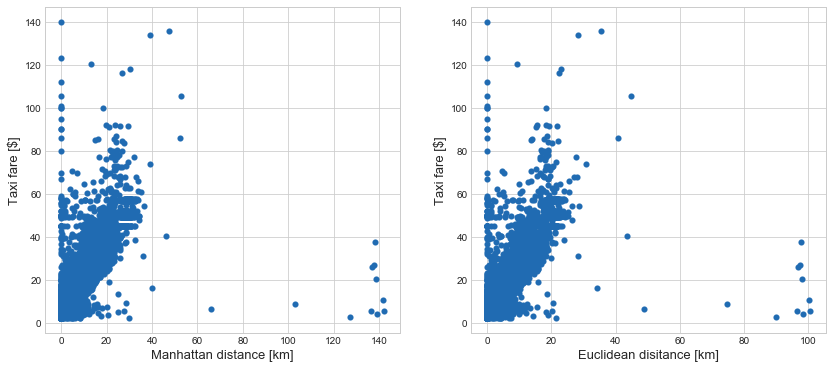

In [44]:
fig,axs = plt.subplots(1,2,figsize=(14,6))

axs[0].scatter(delta['manhattan'],delta['fare_amount'],color=(32/255,107/255,178/255),linewidth=0.1)
axs[0].set_xlabel('Manhattan distance [km]',fontsize=13)
axs[0].set_ylabel('Taxi fare [$]',fontsize=13)

axs[1].scatter(delta['euclidean'],delta['fare_amount'],color=(32/255,107/255,178/255),linewidth=0.1)
axs[1].set_xlabel('Euclidean disitance [km]',fontsize=13)
axs[1].set_ylabel('Taxi fare [$]',fontsize=13)

In [45]:
borders_map = [-74.3, -73.7, 40.5, 40.9]

NYC_map = plt.imread('NYC_map.png')

In [46]:
jfk = (-73.782, 40.644)
ewr = (-74.175, 40.69)
lgr = (-73.87, 40.77)

In [47]:
def plot_on_map(data, nyc_map, borders, s=10, alpha=0.2):
    fig,axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(data.pickup_longitude, data.pickup_latitude, zorder=1, alpha=alpha, color=(32/255,107/255,178/255), s=s)
    axs[0].scatter(jfk[0],jfk[1],color='r',linewidth = 0.7,marker = 'X')
    axs[0].scatter(lgr[0],lgr[1],color='r',linewidth = 0.7,marker = 'X')
    axs[0].scatter(ewr[0],ewr[1],color='r',linewidth = 0.7,marker = 'X')
    axs[0].set_xlim((borders[0],borders[1]))
    axs[0].set_ylim((borders[2],borders[3]))
    axs[0].set_title('Start location',fontsize=13)
    axs[0].imshow(nyc_map, zorder=0, extent = borders)
    
    axs[1].scatter(data.dropoff_longitude, data.dropoff_latitude, zorder=1, alpha=alpha, color=(32/255,107/255,178/255), s=s)
    axs[1].scatter(jfk[0],jfk[1],color='r',linewidth = 0.7,marker = 'X')
    axs[1].scatter(lgr[0],lgr[1],color='r',linewidth = 0.7,marker = 'X')
    axs[1].scatter(ewr[0],ewr[1],color='r',linewidth = 0.7,marker = 'X')
    axs[1].set_xlim((borders[0],borders[1]))
    axs[1].set_ylim((borders[2],borders[3]))
    axs[1].set_title('End location',fontsize=13)
    axs[1].imshow(nyc_map, zorder=0, extent = borders)
    plt.savefig("img/start_end_location.png" ,bbox_inches='tight')

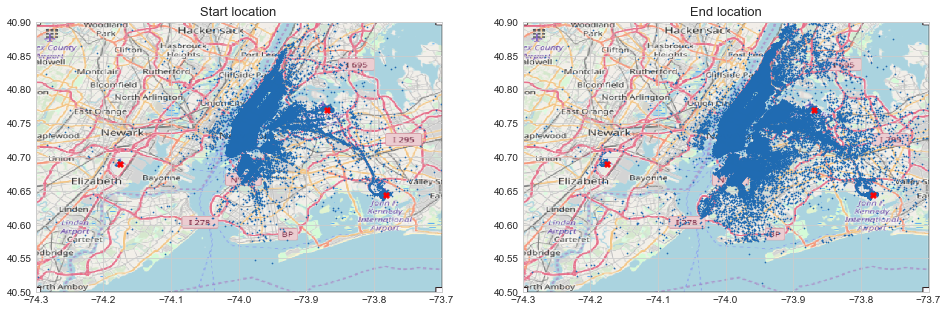

In [48]:
delta2 = data.sample(300000)
plot_on_map(delta2, NYC_map, borders_map, s=0.5, alpha=1)

### Define function that calculates haversine distance between two points (using coordinates)

In [49]:
def distance(latitude1, longitude1, latitude2, longitude2):
    #radius of earth
    R = 6371    
    
    #degrees to radians
    lon1 = np.deg2rad(longitude1)
    lon2 = np.deg2rad(longitude2)
    lat1 = np.deg2rad(latitude1)
    lat2 = np.deg2rad(latitude2)
    
    a = np.sin((lat2-lat1)/2)**2 + ( np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2)**2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R*c
        
    return distance

In [50]:
def plot_around_location_fare(coordinates, airport_name, distance_limit_km, save_name):
    fig, axs = plt.subplots(1,2,figsize=(12,3))
    
    idx = (distance(data.pickup_latitude, data.pickup_longitude, coordinates[1], coordinates[0]) < distance_limit_km)
    data[idx].fare_amount.hist(bins=100,ax=axs[0],color=(32/255,107/255,178/255))
    axs[0].set_xlabel('Taxi fare [$]',fontsize=12)
    axs[0].set_ylabel('Frequency',fontsize=12)
    axs[0].set_title('Histogram of taxi rides starting \nin less than {} kilometer from {}'.format(distance_limit_km, airport_name))
    
    idx = (distance(data.dropoff_latitude, data.dropoff_longitude, coordinates[1], coordinates[0]) < distance_limit_km)
    data[idx].fare_amount.hist(bins=100,ax=axs[1],color=(32/255,107/255,178/255))
    axs[1].set_xlabel('Taxi fare [$]',fontsize=12)
    axs[1].set_ylabel('Frequency',fontsize=12)
    axs[1].set_title('Histogram of taxi rides ending \nin less than {} kilometer from {}'.format(distance_limit_km, airport_name))
    
    plt.savefig(save_name ,bbox_inches='tight')

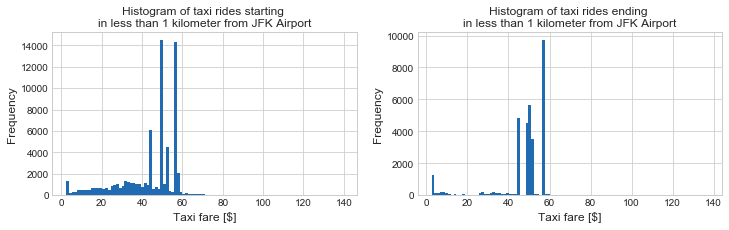

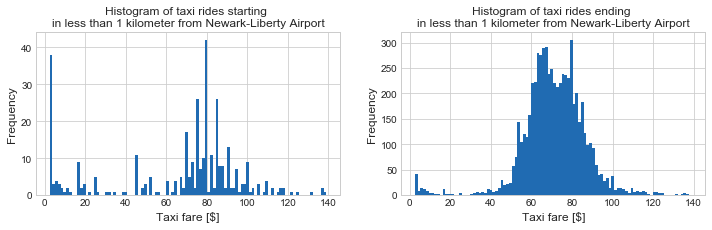

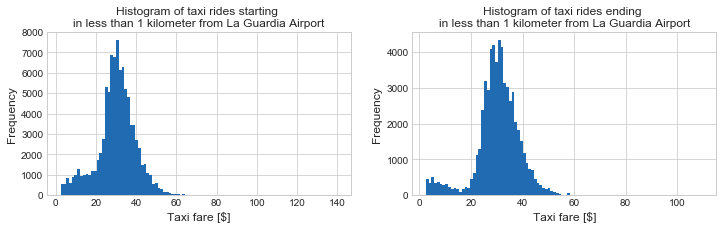

In [51]:
plot_around_location_fare(jfk,'JFK Airport',1,"img/hist_jfk.png")
plot_around_location_fare(ewr,'Newark-Liberty Airport',1,"img/hist_ewr.png")
plot_around_location_fare(lgr,'La Guardia Airport',1, "img/hist_lgr.png")

In [52]:
def if_airport(data, airport_name, coordinates, distance_limit_km = 1):
    
    data['distance_from_'+airport_name+'_start'] = distance(data.pickup_latitude, data.pickup_longitude, coordinates[1], coordinates[0])
    data['distance_from_'+airport_name+'_end'] = distance(data.dropoff_latitude, data.dropoff_longitude, coordinates[1], coordinates[0])
    data['distance_from_'+airport_name] = data[['distance_from_'+airport_name+'_start','distance_from_'+airport_name+'_end']].min(axis=1)
    
    if_close = ['is_'+airport_name,'isnt_'+airport_name]
    limits = [
        (data['distance_from_'+airport_name] <= distance_limit_km),
        (data['distance_from_'+airport_name] > distance_limit_km)]
    
    data[airport_name] = (np.select(limits, if_close)).astype('str')
    
    data = data.drop(['distance_from_'+airport_name+'_start','distance_from_'+airport_name+'_end','distance_from_'+airport_name],axis=1)
    
    return data

In [53]:
data = if_airport(data, 'jfk',jfk)
data = if_airport(data, 'lgr',lgr)
test = if_airport(test, 'jfk',jfk)
test = if_airport(test, 'lgr',lgr)

### Making binary variables from categorical columns

In [54]:
def oneHot(data, col):
    data = pd.concat([data,pd.get_dummies(data[col])],axis=1)
    return data

In [55]:
data = oneHot(data, 'jfk')
data = oneHot(data, 'lgr')
test = oneHot(test, 'jfk')
test = oneHot(test, 'lgr')

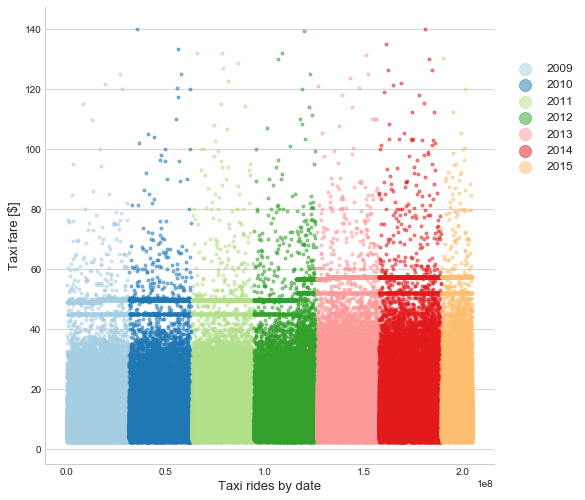

In [62]:
fig = sns.lmplot('elapsed', 'fare_amount', hue='pickup_year', palette = palette, height = 7,legend = False, scatter_kws = {'alpha': 0.5}, markers ='.', fit_reg = False, data = data.sample(300000))
plt.xlabel('Taxi rides by date',fontsize=13)
plt.ylabel('Taxi fare [$]',fontsize=13)
plt.grid(axis='x')
lgd = plt.legend(loc=1,prop={'size': 12},markerscale = 4,bbox_to_anchor = (1.2,0.9))
plt.savefig("img/taxifare_time.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show(fig)

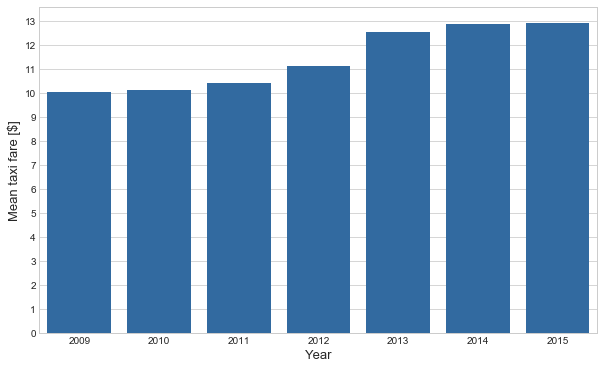

In [63]:
fare_mn = data.groupby('pickup_year')['fare_amount'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x = 'pickup_year', y = 'fare_amount', data = fare_mn, linewidth = 1,color=(32/255,107/255,178/255))
plt.xlabel("Year",fontsize=13)
plt.yticks(np.arange(0, 14, step=1))
plt.ylabel("Mean taxi fare [$]",fontsize=13)
plt.savefig("img/hist_taxifare_year", bbox_inches='tight')
plt.show()

In [64]:
def if_after_08_2012(data):
    limit = dt.datetime(2012,8,31)
    day = ['before_08_2012','after_2012']
    limits = [
        (data['pickup_datetime'] <= limit),
        (data['pickup_datetime'] > limit)]
    
    data['08_2012'] = np.select(limits, day)
    
    data['08_2012'] = data['08_2012'].astype('str')
    
    return data

In [65]:
data = if_after_08_2012(data)
test = if_after_08_2012(test)

In [66]:
data = oneHot(data, '08_2012')
test = oneHot(test, '08_2012')

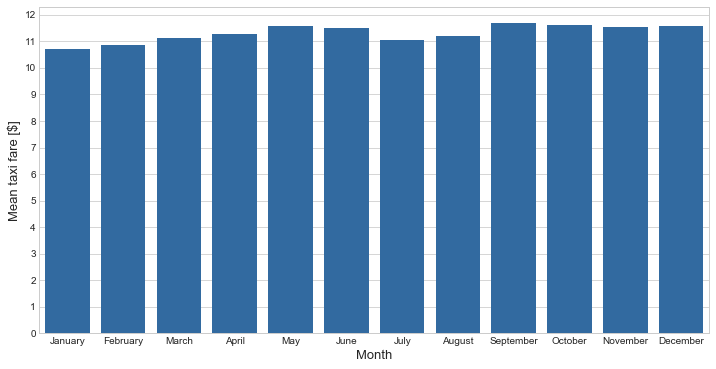

In [67]:
fare_mn = data.groupby('pickup_month')['fare_amount'].mean().reset_index()

mnth_ord = [1,2,3,4,5,6,7,8,9,10,11,12]

plt.figure(figsize=(12,6))
sns.barplot(x = 'pickup_month', y = 'fare_amount', data = fare_mn, linewidth = 1,color=(32/255,107/255,178/255))
plt.xlabel("Month",fontsize=13)
plt.xticks(np.arange(12),('January', 'February', "March", 'April', 'May', 'June', "July",'August','September','October','November','December'))
plt.yticks(np.arange(0, 13, step=1))
plt.ylabel("Mean taxi fare [$]",fontsize=13)
plt.savefig("img/taxifare_month", bbox_inches='tight')
plt.show()

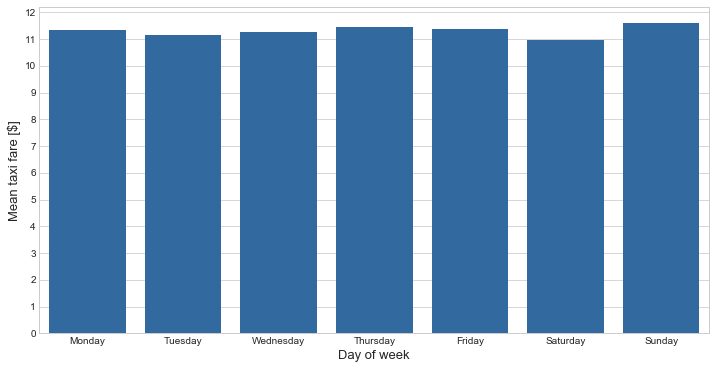

In [68]:
fare_mn = data.groupby('pickup_day_of_week')['fare_amount'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x = 'pickup_day_of_week', y = 'fare_amount', data = fare_mn, linewidth = 1,color=(32/255,107/255,178/255))

plt.xlabel("Day of week",fontsize=13)
plt.xticks(np.arange(7),('Monday', 'Tuesday', "Wednesday", 'Thursday', 'Friday', 'Saturday', "Sunday"))
plt.yticks(np.arange(0, 13, step=1))
plt.ylabel("Mean taxi fare [$]",fontsize=13)
plt.show()

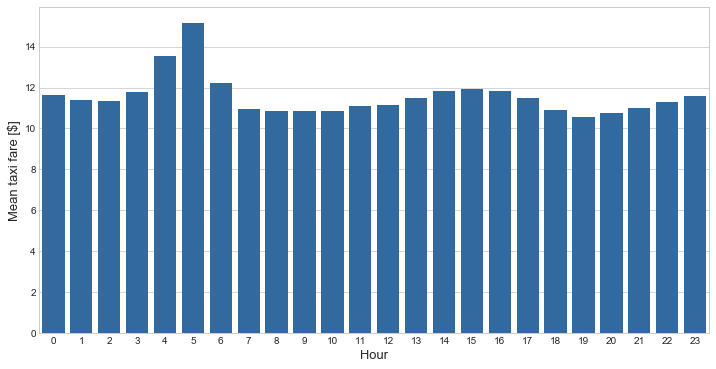

In [69]:
fare_mn = data.groupby('pickup_hour')['fare_amount'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x = 'pickup_hour', y = 'fare_amount', data = fare_mn, linewidth = 1,color=(32/255,107/255,178/255))
plt.xlabel("Hour",fontsize=13)
plt.ylabel("Mean taxi fare [$]",fontsize=13)
plt.show()

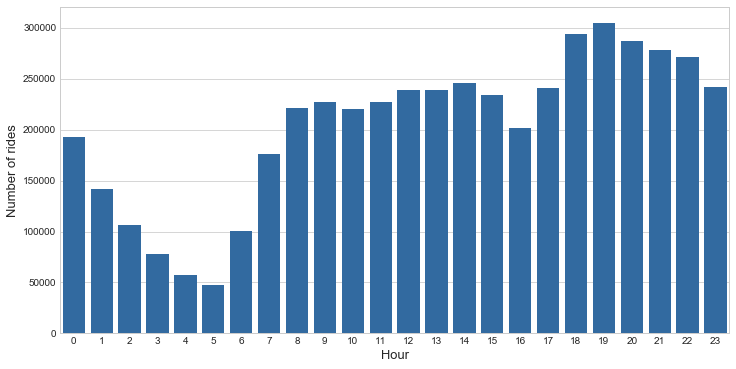

In [71]:
rides = data['pickup_hour'].value_counts(sort = False)
rides = rides.to_frame()
rides['hour'] = rides.index
rides['num_of_rides'] = rides['pickup_hour']

fare_mn = data.groupby('pickup_hour')['fare_amount'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x = 'pickup_hour', y = 'fare_amount', data = fare_mn, linewidth = 1,color=(32/255,107/255,178/255))
plt.grid(True)
sns.barplot(x='hour',y='num_of_rides',data=rides,color=(32/255,107/255,178/255))
plt.xlabel('Hour',fontsize=13)
plt.ylabel('Number of rides',fontsize=13)

plt.show()

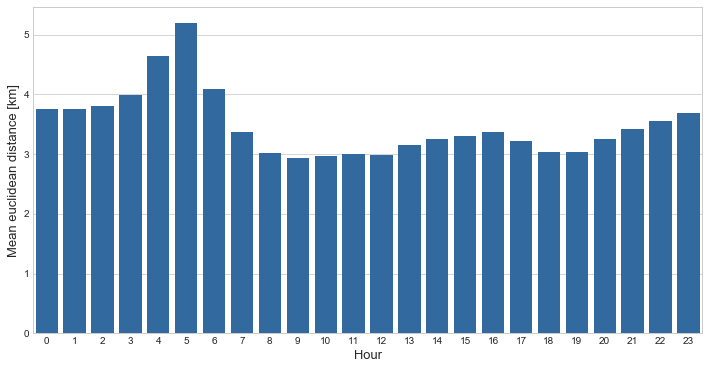

In [72]:
fare_mn = data.groupby('pickup_hour')['euclidean'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x = 'pickup_hour', y = 'euclidean', data = fare_mn, linewidth = 1,color=(32/255,107/255,178/255))
plt.xlabel("Hour",fontsize=13)
plt.ylabel("Mean euclidean distance [km]",fontsize=13)
plt.show()

In [74]:
def if_hour_16_20_weekdays(data):
    time_of_day = ['is_16_20','isnt_16_20']
    limits = [
        ((data['pickup_hour'] >= 16) & (data['pickup_hour'] < 20) & (data['pickup_day_of_week'] >= 1) & (data['pickup_day_of_week'] <= 5)),
        (data['pickup_hour']>=0)]
    
    data['if_hour_16_20_weekdays'] = np.select(limits, time_of_day)
    
    return data

In [75]:
def if_hour_20_6(data):
    time_of_day = ['is_20_6','isnt_20_6']
    limits = [
        ((data['pickup_hour'] >= 20) | (data['pickup_hour'] <= 6)),
        ((data['pickup_hour']>=7) & ((data['pickup_hour'] <= 19)))]
    
    data['if_hour_20_6'] = np.select(limits, time_of_day)
    
    return data

In [76]:
data = if_hour_16_20_weekdays(data)
data = if_hour_20_6(data)
test = if_hour_16_20_weekdays(test)
test = if_hour_20_6(test)

In [77]:
data = oneHot(data,'if_hour_16_20_weekdays')
data = oneHot(data, 'if_hour_20_6')
test = oneHot(test, 'if_hour_16_20_weekdays')
test = oneHot(test,'if_hour_20_6')

In [78]:
data.groupby('passenger_count')['fare_amount','euclidean'].agg(['mean','count'])

fare_amount          euclidean         
                       mean    count      mean    count
passenger_count                                        
1                    11.167  3383902     3.276  3383902
2                    11.783   723422     3.507   723422
3                    11.534   214761     3.393   214761
4                    11.742   103867     3.446   103867
5                    11.194   346024     3.334   346024
6                    12.142   103527     3.406   103527

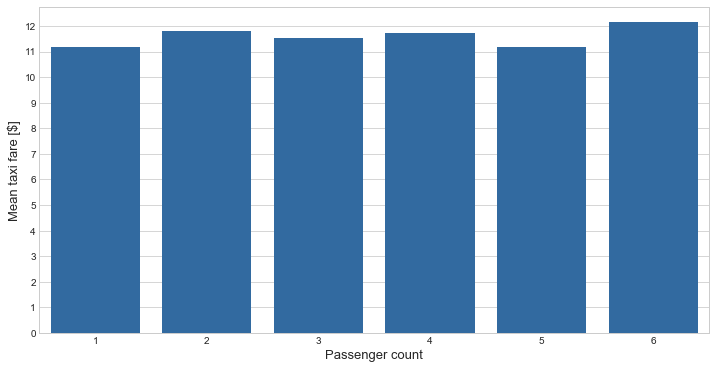

In [79]:
fare_mn = data.groupby('passenger_count')['fare_amount'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x = 'passenger_count', y = 'fare_amount', data = fare_mn, linewidth = 1,color=(32/255,107/255,178/255))
plt.xlabel('Passenger count',fontsize=13)
plt.yticks(np.arange(0, 13, step=1))
plt.ylabel('Mean taxi fare [$]',fontsize=13)
plt.show()

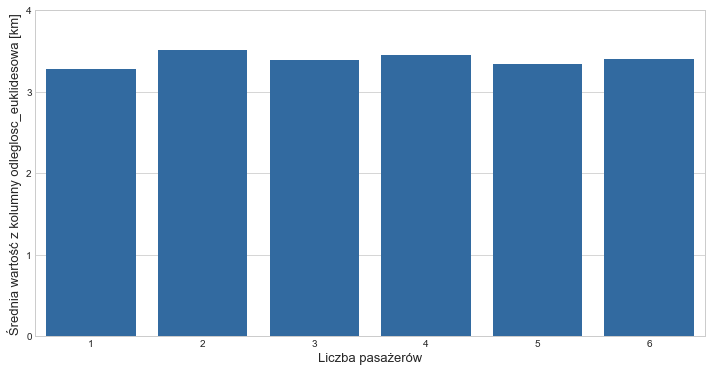

In [75]:
fare_mn = data.groupby('passenger_count')['euclidean'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x = 'passenger_count', y = 'euclidean', data = fare_mn,color=(32/255,107/255,178/255))
plt.xlabel('Liczba pasażerów',fontsize=13)
plt.yticks(np.arange(0, 5, step=1))
plt.ylabel("Średnia wartość z kolumny odleglosc_euklidesowa [km]",fontsize=13)
plt.show()

Text(0, 0.5, 'Pearson correlation')

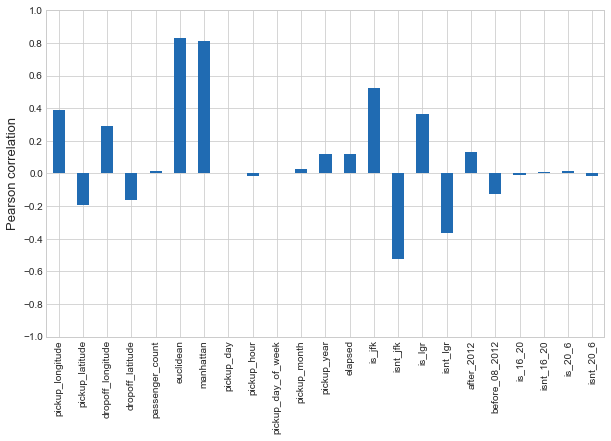

In [80]:
corrs = data.corr()
corrs = corrs.drop('fare_amount',axis=0)

fig = plt.figure(figsize=(10,6))
corrs['fare_amount'].plot.bar(color=(32/255,107/255,178/255))
plt.yticks(np.arange(-1,1.2, step=0.2))
plt.ylabel('Pearson correlation',fontsize=13)

In [82]:
def normalize2(df):
    result = df.copy()
    for feature_name in df.columns:
        mean_value = df[feature_name].mean()
        std_value = df[feature_name].std()
        result[feature_name] = (df[feature_name] - mean_value) / std_value
    return result

In [83]:
X_train, y_train = prepare_data(data, 'fare_amount',
                                  ['key','pickup_datetime','pickup_day','pickup_day_of_week',
                                   'pickup_hour','elapsed','jfk','lgr','isnt_jfk','isnt_lgr','08_2012','before_08_2012',
                                   'if_hour_16_20_weekdays','isnt_16_20','if_hour_20_6','isnt_20_6','passenger_count'],True)
test_data = prepare_data(test ,'',['key','pickup_datetime','pickup_day','pickup_day_of_week',
                                   'pickup_hour','elapsed','jfk','lgr','isnt_jfk','isnt_lgr','08_2012','before_08_2012',
                                   'if_hour_16_20_weekdays','isnt_16_20','if_hour_20_6','isnt_20_6','passenger_count'],False)
#test_data = test_data.drop('fare_amount',axis=1)

In [84]:
X_train_norm2 = normalize2(X_train)
test_norm2 = normalize2(test_data)

In [85]:
X_train_norm2.dtypes

pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
euclidean            float64
manhattan            float64
pickup_month         float64
pickup_year          float64
is_jfk               float64
is_lgr               float64
after_2012           float64
is_16_20             float64
is_20_6              float64
dtype: object

In [86]:
test_norm2.dtypes

pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
euclidean            float64
manhattan            float64
pickup_month         float64
pickup_year          float64
is_jfk               float64
is_lgr               float64
after_2012           float64
is_16_20             float64
is_20_6              float64
dtype: object

In [87]:
lm = LinearRegression()
lm.fit(X_train_norm2, y_train)

y_pred = np.round(lm.predict(test_norm2),2)

submission = pd.DataFrame({'key':test.key, 'fare_amount':y_pred}, columns=['key','fare_amount'])
submission.to_csv('submission.csv',index=False)

### GridSearchCV - screen is on github

In [ ]:
mlpr = MLPRegressor()
scorer = make_scorer(mean_absolute_error, greater_is_better = False)
parameters = {'batch_size': [32,64,128], 'hidden_layer_sizes': [(1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,),(11,),(12,),(13,)], 'random_state': [1],'max_iter': [1000], 'verbose': ['True']}
clf = GridSearchCV(MLPRegressor(), parameters, verbose=15, n_jobs=-1, scoring = scorer, cv = 3)
clf.fit(X_train_norm2,y_train)

#### Analysing GridSearchCV scores

In [ ]:
print("Najlepszy wynik: %f dla%s" %(clf.best_score_, clf.best_params_))

In [ ]:
means = clf.cv_results_['mean_test_score']
params = clf.cv_results_['params']
for mean, param in zip(means, params):
    print("Wynik:%.4f dla:%r" %(mean,param))

### Using best neural network architecture from GridSearchCV - screen is on github

In [88]:
mlpr = MLPRegressor(random_state = 1, hidden_layer_sizes = (13,), max_iter=1000, batch_size=64, verbose=True)
mlpr.fit(X_train_norm2, y_train)
mlpr.score(X_train_norm2, y_train)
y_pred = np.round(mlpr.predict(test_norm2),2)

submission = pd.DataFrame({'key':test.key, 'fare_amount':y_pred}, columns=['key','fare_amount'])
submission.to_csv('submission.csv',index=False)

Iteration 1, loss = 9.21660252
Iteration 2, loss = 8.26202110
Iteration 3, loss = 8.12717583
Iteration 4, loss = 8.04901837
Iteration 5, loss = 8.00310479
Iteration 6, loss = 7.97343226
Iteration 7, loss = 7.95585209
Iteration 8, loss = 7.94080629
Iteration 9, loss = 7.92842050
Iteration 10, loss = 7.91597391
Iteration 11, loss = 7.90834981
Iteration 12, loss = 7.90125972
Iteration 13, loss = 7.89212047
Iteration 14, loss = 7.88345005
Iteration 15, loss = 7.87426423
Iteration 16, loss = 7.83966743
Iteration 17, loss = 7.77913726
Iteration 18, loss = 7.74146815
Iteration 19, loss = 7.72313393
Iteration 20, loss = 7.70833436
Iteration 21, loss = 7.68895437
Iteration 22, loss = 7.66165912
Iteration 23, loss = 7.51261510
Iteration 24, loss = 7.47985498
Iteration 25, loss = 7.46840354
Iteration 26, loss = 7.46272171
Iteration 27, loss = 7.45667189
Iteration 28, loss = 7.45302916
Iteration 29, loss = 7.44903766
Iteration 30, loss = 7.44544885
Iteration 31, loss = 7.44176841
Iteration 32, los

### The score I got with the model on kaggle is: 3,47 $ (The score in that competition is RMSE)

### The least I got is 3,23 $ (But the structure of NN was (30,30,20,10) so it took more time to build that model)

### I could get better score by:
- using more than 5 mil records (but I don't have good enough PC)
- exploring data further and take out more informations from there (maybe separate rides to and from airports)
- trying with other types of models and different structures of layers in MLP

In [90]:
#mlpr.score(X_train_norm2, y_train)